In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os

# Set a fixed random seed value, for reproducibility
SEED = 2137
np.random.seed(SEED)
tf.random.set_seed(SEED)

# list of exercises files
#EXERCISES = [
#    "biceps_curl_1",
#    "triceps_ext",
#    "noise2",
#    "shoulder_side",
#    "shoulder_front"
#]
#SPECIFY DATA LOCATION
dataset_path = "/home/kwik/PycharmProjects/udp_gui_flet/test csv/"

EXERCISES = [
    os.path.splitext(f)[0]
    for f in os.listdir(dataset_path)
    if os.path.isfile(os.path.join(dataset_path, f)) and f.endswith(".csv")
]
SAMPLES_PER_EXERCISES = 110

NUM_OF_EXERCISES = len(EXERCISES)

# output matrix
ONE_HOT_ENCODED_EXERCISES = np.eye(NUM_OF_EXERCISES)

inputs = []
outputs = []

# reading every csv file and putting it into input and output
for exercise_index in range(NUM_OF_EXERCISES):
  gesture = EXERCISES[exercise_index]
  print(f"Processing index {exercise_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_EXERCISES[exercise_index]
  
  df = pd.read_csv(dataset_path + gesture + ".csv")
  df['r'] = df['r'].astype(float)
  df['p'] = df['p'].astype(float)
  df['y'] = df['y'].astype(float)
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_EXERCISES)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} exercise.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_EXERCISES):
      index = i * SAMPLES_PER_EXERCISES + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          #RPY
          (df['r'].iloc[index] + 180) / 360,
          (df['p'].iloc[index] + 180) / 360,
          (df['y'].iloc[index] + 180) / 360,
          #ACC
          (df['aX'].iloc[index] + 32768) / 65536,
          (df['aY'].iloc[index] + 32768) / 65536,
          (df['aZ'].iloc[index] + 32768) / 65536,
          #GYRO
          (df['gX'].iloc[index] + 2000) / 4000,
          (df['gY'].iloc[index] + 2000) / 4000,
          (df['gZ'].iloc[index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

inputs = np.array(inputs)
outputs = np.array(outputs)


Processing index 0 for gesture 'shoulder_side'.
	There are 35 recordings of the shoulder_side exercise.
Processing index 1 for gesture 'biceps_curl'.
	There are 57 recordings of the biceps_curl exercise.
Processing index 2 for gesture 'triceps_ext'.
	There are 13 recordings of the triceps_ext exercise.
Processing index 3 for gesture 'standing_noise'.
	There are 28 recordings of the standing_noise exercise.
Processing index 4 for gesture 'arnold_press'.
	There are 49 recordings of the arnold_press exercise.


In [50]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)
# Swap the consecutive indexes with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]
# Split into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)
inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("done")

done


In [ ]:
input_length = len(inputs_train[0])  # e.g. 110 samples * 12 features = 1320
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_length,)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(NUM_OF_EXERCISES, activation='softmax')
])

model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',  # classification loss
    metrics=['accuracy']              # track accuracy instead of MAE
)

history = model.fit(
    inputs_train,
    outputs_train,
    epochs=700,
    batch_size=1,
    validation_data=(inputs_validate, outputs_validate),
    callbacks=[early_stop]
)

model.save(os.path.join(dataset_path, "my_model.keras"))


In [ ]:
# build the model and train it
model = tf.keras.Sequential()
loss='categorical_crossentropy'
metrics=['accuracy']
model.add(tf.keras.layers.Dense(50, activation='relu')) 
model.add(tf.keras.layers.Dense(NUM_OF_EXERCISES, activation='softmax')) 
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=700, batch_size=1, validation_data=(inputs_validate, outputs_validate))
model.save(os.path.join(dataset_path, "my_model.keras"))

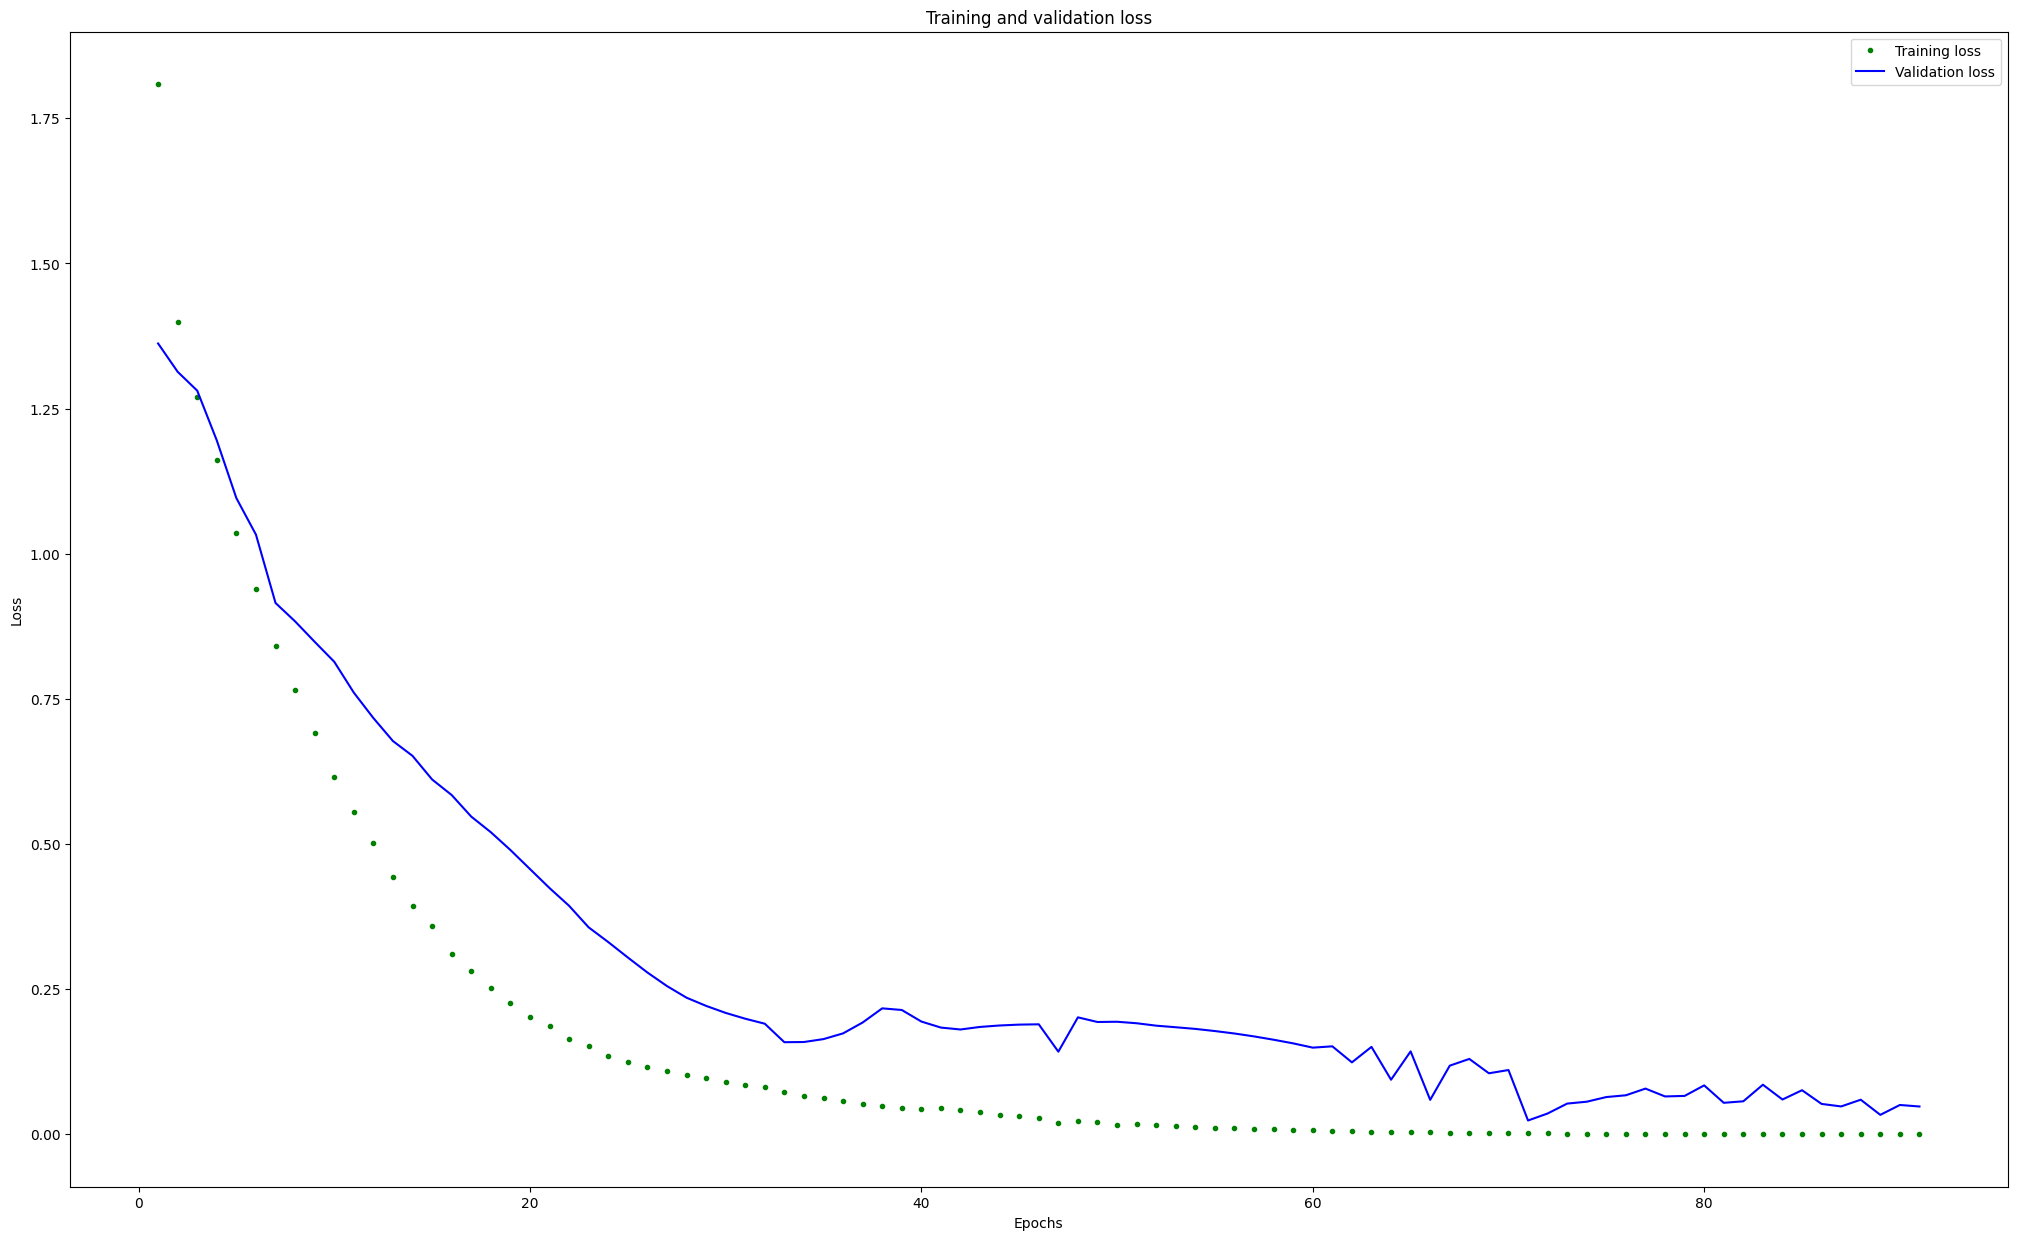

[25.0, 15.0]


In [57]:

plt.rcParams["figure.figsize"] = (25,15)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

In [ ]:

# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

#optimizing
#converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

#open("exercise_model.tflite", "wb").write(tflite_model)
tflite_path = os.path.join(dataset_path, "exercise_model.tflite")
with open(tflite_path, "wb") as f:
    f.write(tflite_model)  

basic_model_size = os.path.getsize("exercise_model.tflite")
print("Model is %d bytes" % basic_model_size)

In [44]:
#!echo "const unsigned char model[] = {" > /home/kwik/PycharmProjects/udp_gui_flet/test csv/my_model.h
#!cat exercise_model.tflite | xxd -i      >> /home/kwik/PycharmProjects/udp_gui_flet/test csv/my_model.h
#!echo "};"                              >> /home/kwik/PycharmProjects/udp_gui_flet/test csv/my_model.h
!echo "const unsigned char model[] = {" > "/home/kwik/PycharmProjects/udp_gui_flet/test csv/my_model.h"
!xxd -i exercise_model.tflite >> "/home/kwik/PycharmProjects/udp_gui_flet/test csv/my_model.h"
!echo "};" >> "/home/kwik/PycharmProjects/udp_gui_flet/test csv/my_model.h"

model_h_size = os.path.getsize("/home/kwik/PycharmProjects/udp_gui_flet/test csv/my_model.h")
print(f"Header file, model.keras, is {model_h_size:,} bytes.")

Header file, model.keras, is 831,814 bytes.
